---
layout: post
title: "AE2. Variation AE - 변이형 오토인코더란?"
author: "Chanjun Kim"
categories: Data분석
tags: [Data, AutoEncoder, AE, Gan, Denoising AE, VAE, 딥러닝, CNN]
image: 08_AutoEncoder.png
---

## **학습목적**
이 포스팅에선 저번 포스팅에서 알아본 오터인코더의 단점을 보완한 변이형 오토인코더에 대해서 알아보도록 하겠습니다.

#### **변이형 오토인코더란?**
- 오토인코더(Autoencoder)의 기본적인 개념은 저차원(직관적)인 데이터를 고차원(추상적)의 데이터로 표현(representation)하고 다시 저차원의 데이터로 만들어 데이터 생성, 노이즈 제거, 특성 변화 등을 할 수 있도록 만들어주는 기법으로, 오토 인코더라고 불리지만 실제로는 인코더와 디코더가 같이 묶여있는 네트워크입니다.
    - **오터인코더의 한계 :**
        - 모든 데이터가 인코더를 거치며 정확히 구분되지 않을 뿐 아니라 잠재 공간 모두에 분포하지 않습니다. 즉, 잠재공간이 존재하지만 엉뚱한 곳을 찍었을 때는 전혀 다른 데이터를 생성할 수 있습니다.

<br>

---

#### **VAE(Variational Autoencoder) - 변이형 오토인코더**
- 오토인코더(Autoencoder)의 기본적인 개념은 저차원(직관적)인 데이터를 고차원(추상적)의 데이터로 표현(representation)하고 다시 저차원의 데이터로 만들어 데이터 생성, 노이즈 제거, 특성 변화 등을 할 수 있도록 만들어주는 기법으로, 오토 인코더라고 불리지만 실제로는 인코더와 디코더가 같이 묶여있는 네트워크입니다.
    - 저차원과 고차원
        - 인코더는 차원 축소라고 표현되나, 잠재공간(Latent Space)가 늘어나며 추상적인 고차원 데이터로 변환됩니다..
        - 128x128x3의 이미지는 사람의 눈으로도 판단 가능한 직관적인 데이터지만 2x2x32 같이 잠재공간(Latent Space)가 많은 경우는 사람의 눈으로는 판단할 수 없는 추상적인 데이터라고 볼 수 있습니다.


---

#### **오토인코더 실습**

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd drive/MyDrive/cj/portfolio/Chanjun-kim.github.io/_ipynb
!pwd

Mounted at /content/drive
/content/drive/MyDrive/cj/portfolio/Chanjun-kim.github.io/_ipynb
/content/drive/MyDrive/cj/portfolio/Chanjun-kim.github.io/_ipynb


In [1]:
import os
import sys
import warnings

import random

import numpy as np
import pandas as pd

import scipy
import scipy.stats
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib as mpl
import matplotlib.pyplot as plt
from plotnine import * 

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist, fashion_mnist

In [2]:
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [3]:
class VariationalAutoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        
        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)
        
        

        ### THE DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)


    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            
            return  r_loss + kl_loss


        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])

    def train(self, x_train, y_train, batch_size, epochs):
        self.model.fit(     
            x_train 
            , y_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
        )

    def train_with_generator(self, data_flow, epochs):
        self.model.fit_generator(
            data_flow
            , shuffle = True
            , epochs = epochs
            )
        
        

In [4]:
vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

In [5]:
vae.encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [6]:
vae.decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

In [7]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

In [8]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)


In [9]:
BATCH_SIZE = 32
EPOCHS = 200


In [17]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [15]:
x_train.shape

(60000, 28, 28, 1)

In [18]:
vae.train(x_train, x_train, batch_size = BATCH_SIZE, epochs = EPOCHS)


ValueError: Calling `Model.fit` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.fit` with eager mode enabled.

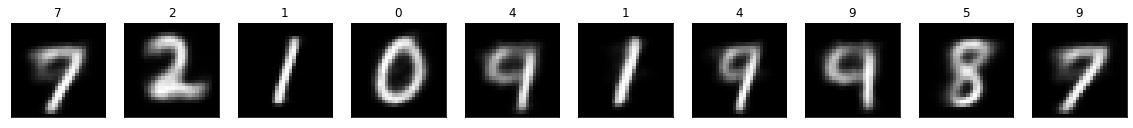

In [ ]:
vae_predict = vae.model.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.reshape(vae_predict[i], (28, 28)))
    plt.title(y_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
latent_splace_x_test = pd.DataFrame(vae.encoder.predict(x_test), columns = ["x", "y"])
latent_splace_x_test["label"] = y_test
latent_splace_x_test["label"] = latent_splace_x_test.label.astype(str)

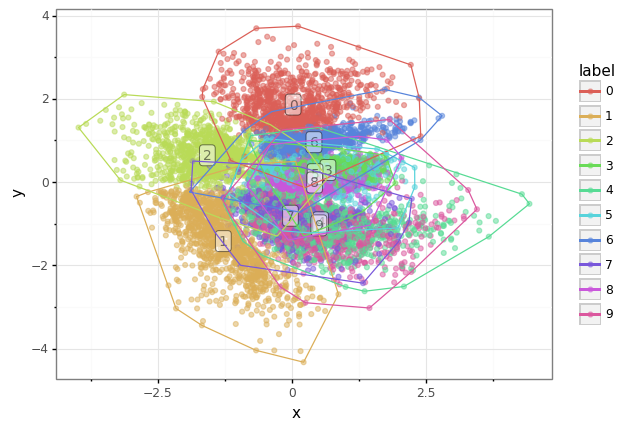

<ggplot: (8763241035985)>

In [ ]:
(
    ggplot() +   
    geom_point(data = latent_splace_x_test, mapping = aes(x = "x", y = "y", color = "label"), alpha = 0.5) + 
    geom_label(data = latent_splace_x_test.groupby("label").mean(["x", "y"]).reset_index(), mapping = aes(x = "x", y = "y", label = "label"), size = 10, alpha = 0.5) +
    stat_hull(data = latent_splace_x_test, mapping = aes(x = "x", y = "y", color = "label")) +
    theme_bw()
)

In [ ]:
rv = spicy.stats.norm()

In [ ]:
cdf = rv.cdf(latent_splace_x_test[["x", "y"]])

In [ ]:
latent_splace_x_test = pd.concat([latent_splace_x_test, pd.DataFrame(cdf).rename(columns = {0 : "x", 1 : "y"}).add_prefix("cdf_")], axis = 1)

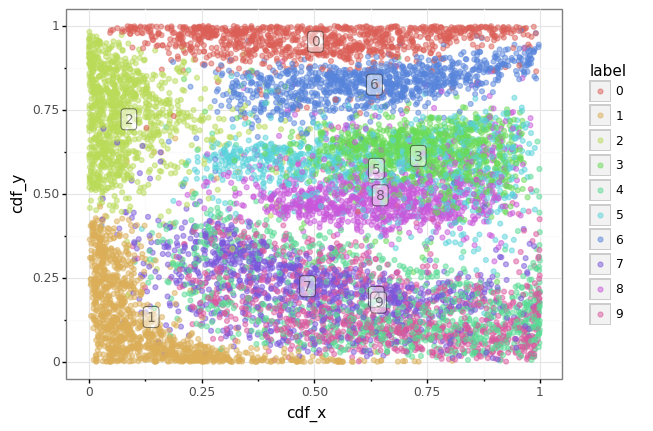

<ggplot: (8763239849497)>

In [ ]:
(
    ggplot() +   
    geom_point(data = latent_splace_x_test, mapping = aes(x = "cdf_x", y = "cdf_y", color = "label"), alpha = 0.5) + 
    geom_label(data = latent_splace_x_test.groupby("label").mean(["cdf_x", "cdf_y"]).reset_index(), mapping = aes(x = "cdf_x", y = "cdf_y", label = "label"), size = 10, alpha = 0.5) +
    theme_bw()
)

In [ ]:
vae.train(x_train, x_train, batch_size = BATCH_SIZE, epochs = EPOCHS)

- #### **결론 :**
    - **오토인코더를 왜 쓰는가?**
        - 인코더를 거치면 일종의 차원축소처럼 보이게되는데 이 때 확실한 영역을 구분하게 된다면, 그 주변의 좌표들을 통하여 비슷한 이미지를 생성하는데 기여할 수 있습니다.
    - **오터인코더의 한계?**
        - 모든 데이터가 인코더를 거치며 정확히 구분되지 않을 뿐 아니라 잠재 공간 모두에 분포하지 않습니다. 즉, 잠재공간이 존재하지만 엉뚱한 곳을 찍었을 때는 전혀 다른 데이터를 생성할 수 있습니다.

---

code : https://github.com/Chanjun-kim/Chanjun-kim.github.io/blob/main/_ipynb/2021-07-25-AE1_AutoEncoder.ipynb

> 참고자료 : [https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko](https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko)<br>
> 참고자료 : [https://github.com/davidADSP/GDL_code](https://github.com/davidADSP/GDL_code)<br>